# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/bjet_binned_test/'
selections = [
              'emu', 
              'mumu',  'mutau', 'mu4j',
              'ee',  'etau', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )
#p_labels = [r'$\beta_{e}$', r'$\beta_{\mu}$', r'$\beta_{\tau}$', r'$\beta_{h}$',
#            r'$\sf L_{int}$', 
#            r'$\sigma_{t\bar{t}}$',  r'$\sigma_{z}$',  r'$\sigma_{w}$', r'$\sf k_{fakes}$', 
#            r'$\sf \epsilon_{e}$', r'$\sf \epsilon_{\mu}$', r'$\sf \epsilon_{\tau}$']

p_labels = ['B_e', 'B_mu', 'B_tau', 'B_h', 
            'L', 
            'sigma_tt', 'sigma_tW', 'sigma_z', 'sigma_w', 'sigma_diboson', 'k_fake', 
            'trigger_e', 'trigger_mu',
            'eff_e', 'eff_mu', 'eff_tau', 
            'pileup', 
            'escale_e', 'escale_mu', 'escale_tau', 
            'jes', 'jer', 'btag', 'mistag',
            'fsr', 'isr', 'tune', 'hdamp', 'qcd', 'pdf'
           ]

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets)

In [3]:
# generate Asimov dataset
toy_data = dict()
for selection in selections:
    toy_data[selection] = dict()
    sdata = fit_data.get_selection_data(selection)
    for b, bdata in sdata.items():
        if b == 0: continue
        templates = bdata['templates']
        
        # signal component
        toy_data[selection][b] = np.zeros(bdata['bins'].size - 1)
        for sig in ['ttbar', 't', 'wjets']:
            signal_template = list(templates[sig].values())
            if sig == 'wjets':
                continue
                signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False, single_w=True)[0]
            else:
                signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False)[0]
            toy_data[selection][b] += signal
        
        # background component
        for bg in ['zjets', 'diboson', 'fakes']:
            if bg == 'fakes' and selection not in ['mu4j', 'mutau', 'etau']:
                continue

            toy_data[selection][b] += templates[bg]['val']

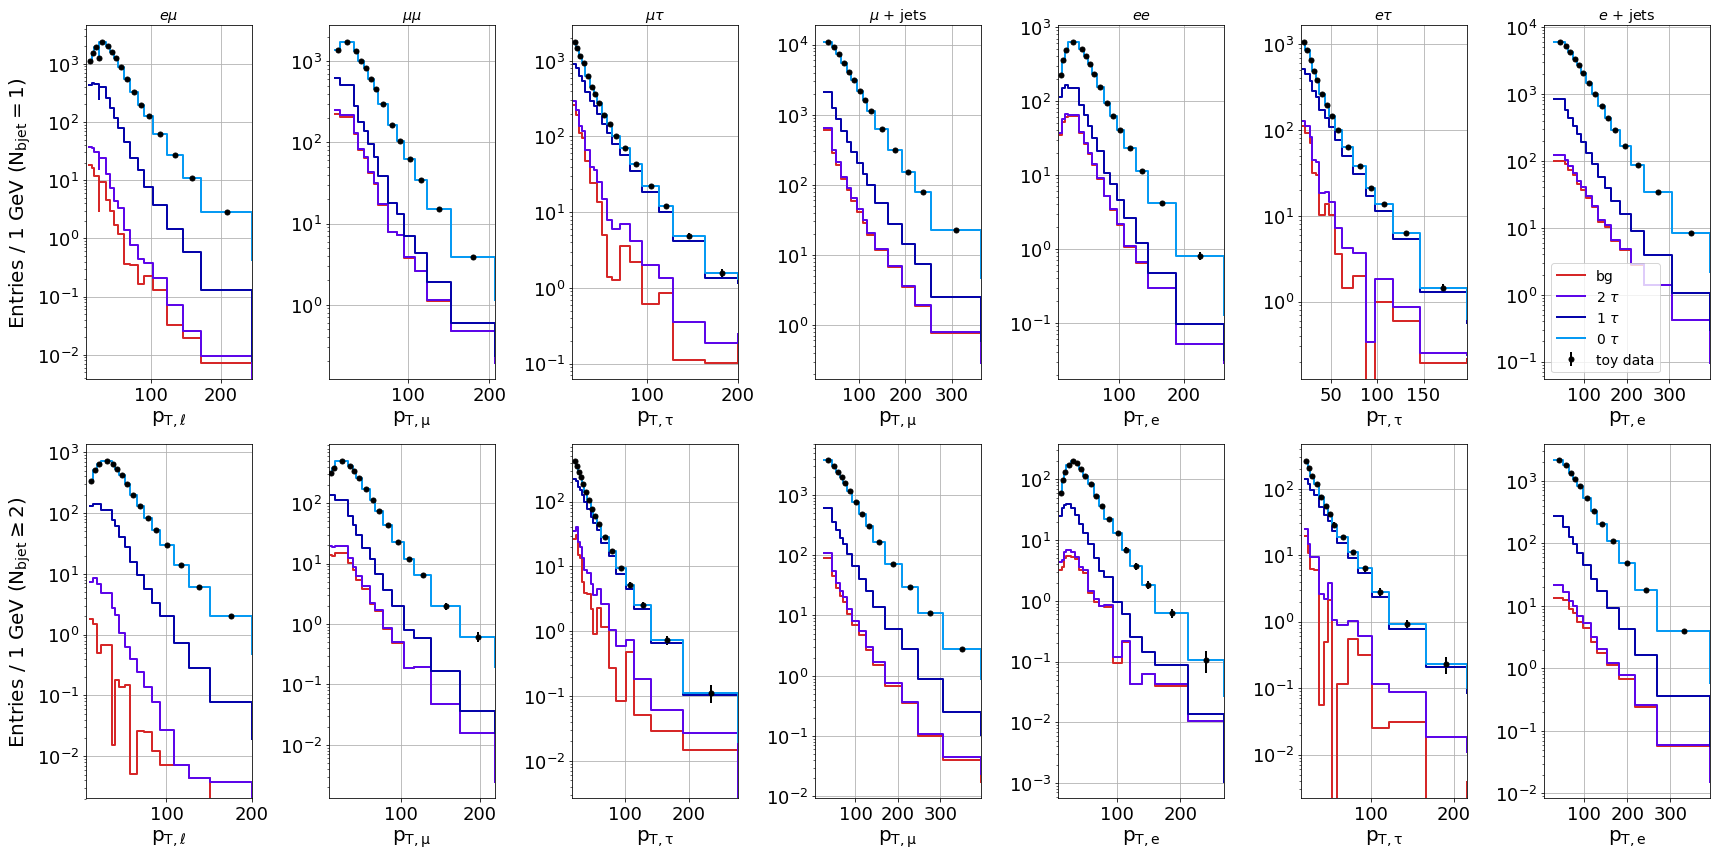

In [4]:
# visualize toy data
fig, axes = plt.subplots(2, 7, figsize=(24, 12), facecolor='white')
for i, selection in enumerate(selections):
    sdata = fit_data.get_selection_data(selection)
    for j, (b, bdata) in enumerate(sdata.items()):
        templates = bdata['templates']
        
        if b == 0: continue # and selection not in ['etau', 'mutau']: continue
            
        # get and plot the data 
        bins = bdata['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        ax = axes[b-1][i]
        data = toy_data[selection][b]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        # background component
        h_bg = np.zeros(data.shape)
        for bg_label in ['zjets', 'diboson', 'fakes']:
            if bg_label == 'fakes' and selection not in ['mu4j', 'mutau', 'etau']:
                continue
            h_bg += templates[bg_label]['val']
        
        ## signal component
        h_twotau   = np.zeros(h_bg.shape)
        h_onetau  = np.zeros(h_bg.shape)
        h_nominal = np.zeros(h_bg.shape)
        for sig in ['ttbar', 't', 'wjets']:
            signal_template = list(templates[sig].values())

            if sig == 'wjets':
                continue
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)[0]
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)[0]
            else:
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])[0]
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])[0]
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)[0]
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2.)
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2.)
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2.)
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2.)
        
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        if j == 0 or (selection in ['etau', 'mutau'] and j == 1):
            ax.set_title(plot_labels[selection][1])
            
        if b == 0:
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 0$)')
        elif b == 1:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 1$)')
        elif b == 2:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} \geq 2$)')
        ax.grid()
    
    axes[0][-1].legend(['bg', r'2 $\tau$', r'1 $\tau$', r'0 $\tau$', 'toy data'], fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example.pdf')
plt.show()

In [5]:
# nominal case
cost_type = 'poisson'
p_init = list(fit_data.get_params_init()) + 26*[1., ] # niceify this: nuisance parameters are initialized to 1
p_init = np.array(p_init)
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr, corr = fh.calculate_covariance(fobj, p_init)

/home/naodell/work/wbr/analysis/scripts/fit_helpers.py:497: RuntimeWarning: invalid value encountered in sqrt
  sig         = np.sqrt(hinv.diagonal())


In [6]:
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', len(p_labels))
pd.set_option('display.max_rows', len(p_labels))

#print(result.x)
#print(cov[0])
pct_err = pd.DataFrame(100*stderr/p_init, index=p_labels, columns=['stderr'])
df_corr = pd.DataFrame(corr, columns=p_labels, index=p_labels)
pct_err

,stderr
B_e,0.478
B_mu,0.447
B_tau,1.899
B_h,0.275
L,0.384
sigma_tt,0.431
sigma_tW,5.129
sigma_z,3.979
sigma_w,5.000
sigma_diboson,9.992


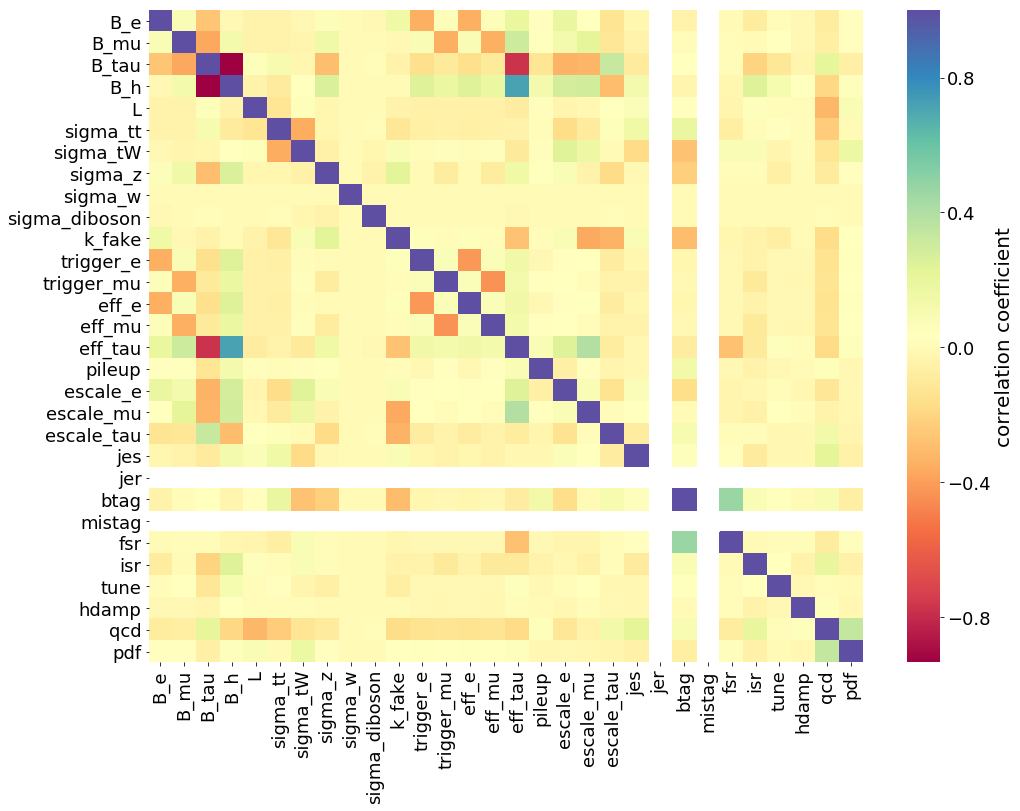

In [ ]:
df_corr.to_latex('data/cov_table_full.tex')
df_corr.to_csv('data/cov_table_full.csv')

import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16, 12))
sns.heatmap(df_corr, cmap='Spectral', ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.show()

### Estimating individual contributions

If we make the assumption that the uncertainties sum in quadrature (which they should really given all of the correlations), we can write the total uncertainty as,

$$
\sigma_{total}^{2} = \sigma_{stat}^{2} + \sum_{i}\sigma_{i,syst}^{2}
$$

From this we can write evaluate the contribution from a single systematic source as,

$$
\sigma_{i,syst}^{2} = \sigma_{total}^{2} - \sigma_{stat}^{2} - \sum_{j\neq i}\sigma_{j,syst}^{2}
$$


In [ ]:
# n-1 uncertainties
from tqdm import tqdm_notebook, trange

def reduced_objective(p, i, j=None):
    if j == None or j < i:
        j = i
        
    p = np.concatenate([p[:i], (j - i + 1)*[1,], p[j:]])
    return fit_data.objective(p, data=toy_data, cost_type=cost_type)

# stat only
fobj = partial(reduced_objective, i=4, j=len(p_init))
stderr_stat = np.concatenate([fh.calculate_covariance(fobj, p_init[:4])[0], p_init[4:].size*[0.,]])

errs = [stderr_stat]
p_init = p_init
for i in tqdm_notebook(range(4, len(p_init))):
    fobj = partial(reduced_objective, i=i)
    stderr, cov = fh.calculate_covariance(fobj, p_init[:-1])
    
    stderr = np.concatenate([stderr[:i], [0], stderr[i:]])
    errs.append(stderr)
    
# full systematics
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr_nominal = fh.calculate_covariance(fobj, p_init)[0]
errs.append(stderr_nominal)

HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

In [ ]:
errs = pd.DataFrame(errs, columns=p_labels, index=['stat only'] + p_labels[4:] + ['full'])
errs.divide(p_init/100, axis=1)

In [ ]:
beta_vars = errs.iloc[:,:4]**2
var_stat = beta_vars.iloc[0]
var_nom  = beta_vars.iloc[-1]

for i in trange(1, beta_vars.shape[0] - 1):
    beta_vars.iloc[i] = var_nom - beta_vars.iloc[i]
    
beta_errs = np.sqrt(beta_vars)
100*beta_errs.divide(p_init[:4], axis=1)